# Classification of a dataset with MetaCLIP

## Installing dependencies


In [1]:
! pip install transformers torch faiss-gpu datasets matplotlib scikit-learn

## Loading the model

In [8]:
import torch
from PIL import Image
from datasets import load_dataset
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification, AutoTokenizer
from tqdm import tqdm
#Only needed in Google colab
import torch._dynamo
torch._dynamo.config.suppress_errors = True

#Define device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

#Load CLIP model, processor and tokenizer
processor = AutoProcessor.from_pretrained("facebook/metaclip-b16-fullcc2.5b")
model = AutoModelForZeroShotImageClassification.from_pretrained("facebook/metaclip-b16-fullcc2.5b",  torch_dtype=torch.float16).to(device)
model = torch.compile(model)
tokenizer = AutoTokenizer.from_pretrained("facebook/metaclip-b16-fullcc2.5b")

## Loading the dataset (CIFAR10)

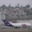

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [9]:
#Load cifar10 dataset
dataset = load_dataset("cifar10")

#Display an image
display(dataset['train'][0]['img'])

#Display the list of labels
labels = dataset["train"].features["label"].names
print(labels)

## Classification of an image

In [ ]:
#Take the first image in the training set
image = dataset['train'][0]['img']

#Function to classify an image among the list of labels
def classify(image, labels):
    with torch.no_grad():
        inputs = processor(text=labels, images=image, return_tensors="pt", padding=True).to(device)
        outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)
    label = probs.argmax()
    return label

l = classify(image,labels)
#The first image seen above was classified as an airplane, which is correct
print(labels[l])

## Classification of all the images in the test set

In [11]:
predictions= []
ground_truth= [d['label'] for d in dataset['test']]

for img in tqdm(dataset['test']):
    pred = classify(img['img'], labels)
    predictions.append(pred.item())

100%|██████████| 10000/10000 [04:35<00:00, 36.34it/s]


## Computing metrics

Accuracy: 0.9501
Precision: 0.9507
Recall: 0.9501
F1 Score: 0.9500

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1000
           1       0.99      0.95      0.97      1000
           2       0.96      0.92      0.94      1000
           3       0.94      0.87      0.90      1000
           4       0.93      0.94      0.93      1000
           5       0.90      0.96      0.93      1000
           6       0.97      0.94      0.96      1000
           7       0.94      0.99      0.97      1000
           8       0.97      0.97      0.97      1000
           9       0.95      0.99      0.97      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000


Confusion Matrix:
[[962   0  17   0   0   0   1   2  17   1]
 [  0 946   0   0   0   0   0   0   0  54]
 [  2   0 918  13  42   7   7   8   3   0]
 [

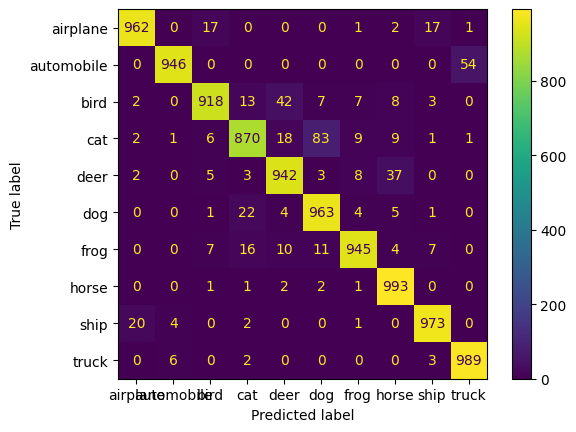

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
y_true = ground_truth
y_pred = predictions

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}')

precision = precision_score(y_true, y_pred, average='weighted')
print(f'Precision: {precision:.4f}')

recall = recall_score(y_true, y_pred, average='weighted')
print(f'Recall: {recall:.4f}')

f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1 Score: {f1:.4f}')

# Generate classification report
print('\nClassification Report:')
print(classification_report(y_true, y_pred))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print('\nConfusion Matrix:')
print(conf_matrix)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=labels)
disp.plot()
plt.show()